### Discovery of interesting peak-gene pairs

In [144]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import anndata as ad

In [145]:
# load data
rna_adata = ad.read_h5ad('./data/rna.h5ad')
atac_adata = ad.read_h5ad('./data/atac.h5ad')
gene_locations = pd.read_table('./data/gene_locations_hg38.tsv', index_col = 'Gene ID', usecols = ['Gene ID', 'Begin', 'End', 'Chromosome', 'Symbol', 'Gene Type', 'Accession'])
gene_locations.drop(index = [idx for idx, accession in gene_locations['Accession'].items() if not accession.startswith('NC')], inplace = True)

#### Prior knowledge validation

Based on prior heart studies in mice, we expect to see:
- Periostin (Postn) expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 peaks to increase with TAC and decrease with TAC+JQ1
  - This data is human so peaks will likely not be 1:1 with mice data

In [146]:
palette = {'Unstim': '#2ca02c', 'TGFb': '#d62728', 'TGFb+JQ1': '#1f77b4'}
markers = {'Lung': 'o', 'Heart': '^', 'Liver': 's'}

In [147]:
# boxplot of expression over organ/condition
def plot_expression(adata: ad.AnnData, gene: str, layer: str = None, **kwargs) -> plt.Axes:
  gene_rna_adata = adata[:, adata.var['gene'] == gene]
  ax = sns.boxplot(gene_rna_adata.obs, x = 'organ', y = gene_rna_adata.to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{gene} expression {layer if layer is not None else ""}')
  return ax

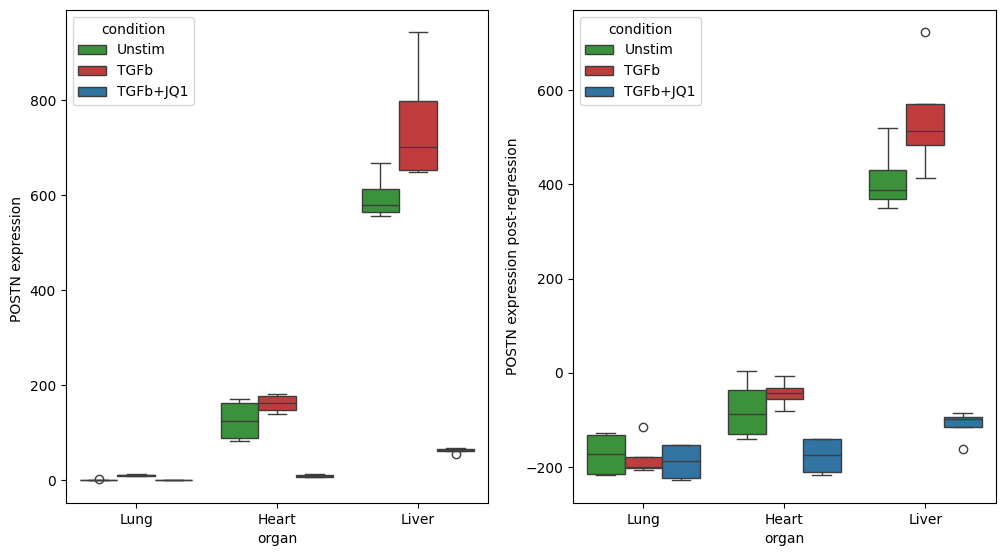

In [148]:
# Periostin expression pre- and post-regression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'POSTN', ax=ax1)
plot_expression(rna_adata, gene = 'POSTN', layer = 'post-regression', ax=ax2)
plt.show()

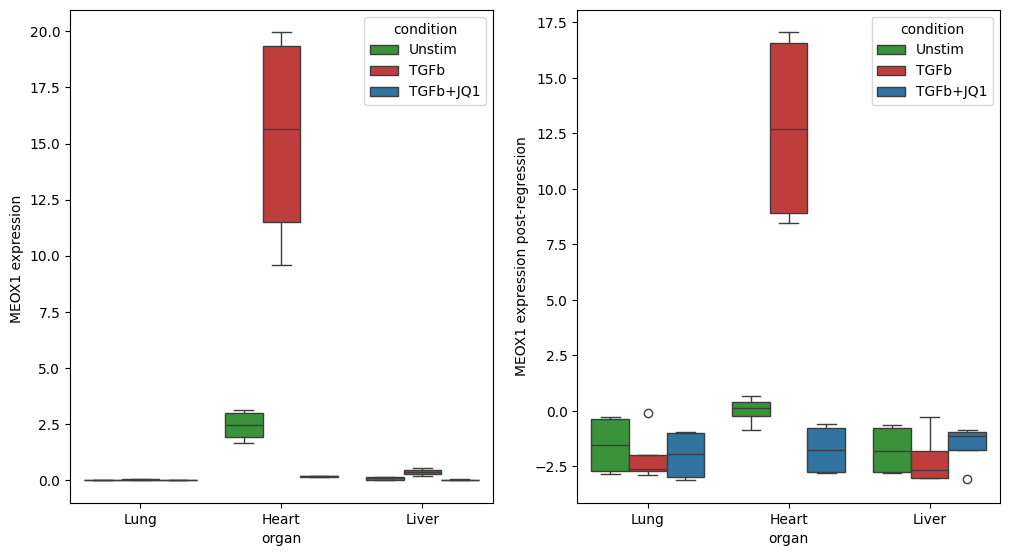

In [149]:
# MEOX1 expression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'MEOX1', ax=ax1)
plot_expression(rna_adata, gene = 'MEOX1', layer = 'post-regression', ax=ax2)
plt.show()

In [150]:
# heatmap of atac peaks over location range. also boxes the (approximate) gene location
def plot_peak_range(adata: ad.AnnData, chr: int, loc: tuple[float, float], layer: str = None, range = 1.5 * 10 ** 5, **kwargs) -> plt.Axes:
  peak_adata = adata[:, (adata.var['Chr'] == f'chr{chr}') & (adata.var['End'] >= loc[0] - range) & (adata.var['Start'] <= loc[1] + range)]
  peak_heatmap_df = pd.DataFrame({
    f"{organ}-{condition}": {
      peak: np.mean(peak_adata[rows.index, peak]._get_X(layer = layer)) for peak in peak_adata.var_names
    }
    for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])
  }, dtype = 'float64')
  peak_heatmap_df = peak_heatmap_df[[f"{organ}-{condition}" for organ in markers.keys() for condition in palette.keys()]]
  ax = sns.heatmap(peak_heatmap_df, cmap = 'viridis', **kwargs)
  ax.set_ylabel("Peak")
  ax.set_xlabel("Organ-Condition")
  coding_index = peak_adata[:, (peak_adata.var['End'] >= loc[0]) & (peak_adata.var['Start'] <= loc[1])].var_names
  ax.add_patch(plt.Rectangle((0, peak_heatmap_df.index.get_loc(coding_index[0])), len(peak_heatmap_df.columns), len(coding_index), fill=False, edgecolor='crimson', lw=2, clip_on=False))
  return ax

In [151]:
meox1_row = gene_locations[gene_locations['Symbol'] == 'MEOX1']
meox1_row

,Accession,Begin,End,Chromosome,Symbol,Gene Type
Gene ID,,,,,,
4222,NC_000017.11,43640389,43661922,17,MEOX1,protein-coding


In [152]:
meox1_row[['Begin', 'End']].values[0]

array([43640389, 43661922])

/scratch/ipykernel_3899579/2366565480.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])
/scratch/ipykernel_3899579/2366565480.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])


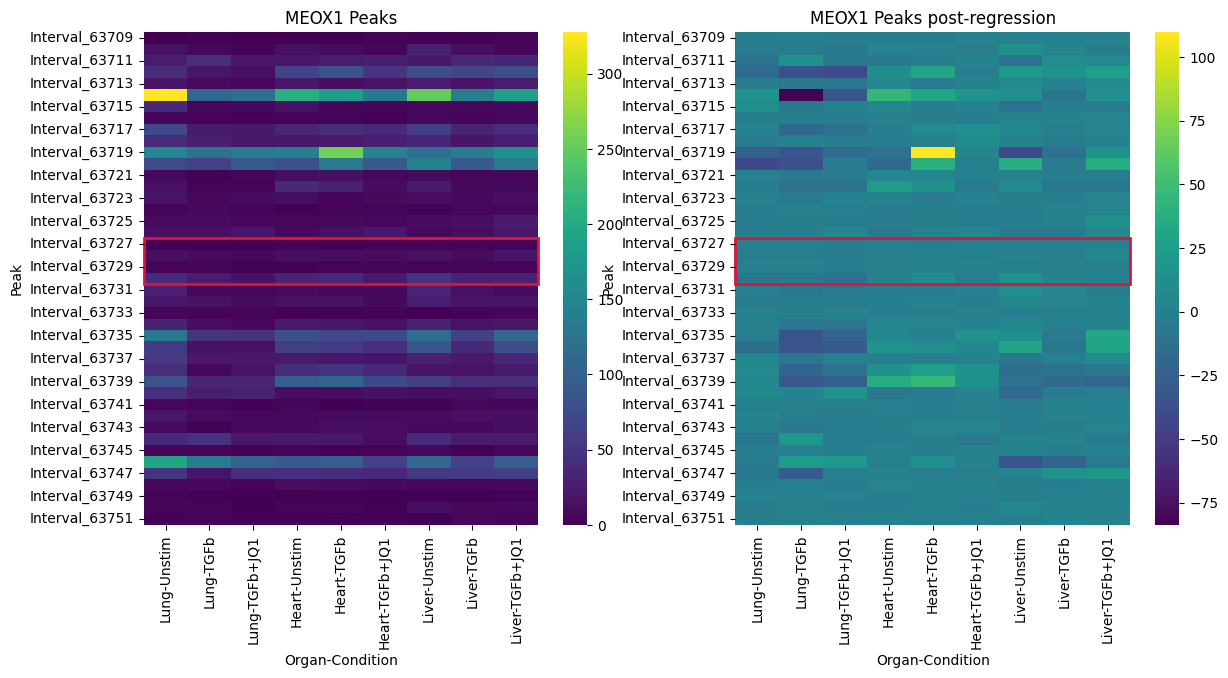

In [153]:
# MEOX1 peaks (Location according to UCSC is chr17, 43.64 - 43.66 Mb, expanding 150kb on either end)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6.4))
plot_peak_range(atac_adata, chr=meox1_row['Chromosome'].values[0], loc=meox1_row[['Begin', 'End']].values[0], ax=ax1)
ax1.set_title("MEOX1 Peaks")
plot_peak_range(atac_adata, chr=meox1_row['Chromosome'].values[0], loc=meox1_row[['Begin', 'End']].values[0], ax=ax2, layer='post-regression')
ax2.set_title("MEOX1 Peaks post-regression")
plt.show()

In [154]:
# chr17:43,616,437-43,616,691 <- orthologous to mouse peak 5
# chr17:43,616,835-43,617,184 <- orthologous to mouse peak 5
# not captured in this data
atac_adata[:, ['Interval_63723', 'Interval_63724']].var

,Chr,Start,End,Strand,Length
Geneid,,,,,
Interval_63723,chr17,43614858,43615602,+,745
Interval_63724,chr17,43622133,43622721,+,589


In [155]:
# chr17:43,591,770-43,592,120 <- orthologous to mouse peak 10
# chr17:43,592,215-43,592,517 <- orthologous to mouse peak 9
# 63720 seems to bridge both of these intervals
atac_adata[:, 'Interval_63720'].var

,Chr,Start,End,Strand,Length
Geneid,,,,,
Interval_63720,chr17,43591191,43592816,+,1626


In [156]:
# chr17:43,577,707-43,577,887 <- orthologous to mouse peak 13
# chr17:43,578,079-43,578,427 <- orthologous to mouse peak 13
# chr17:43,578,441-43,578,702 <- orthologous to mouse peak 13
# regions seem to be directly flanking
atac_adata[:, ['Interval_63718', 'Interval_63719']].var

,Chr,Start,End,Strand,Length
Geneid,,,,,
Interval_63718,chr17,43576650,43577072,+,423
Interval_63719,chr17,43578751,43580003,+,1253


In [157]:
# boxplot of peak over organ/condition
def plot_peak(adata: ad.AnnData, peak: str, layer: str = None, **kwargs) -> plt.Axes:
  ax = sns.boxplot(adata.obs, x = 'organ', y = adata[:, peak].to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{peak} consensus peaks {layer if layer is not None else ""}')
  return ax

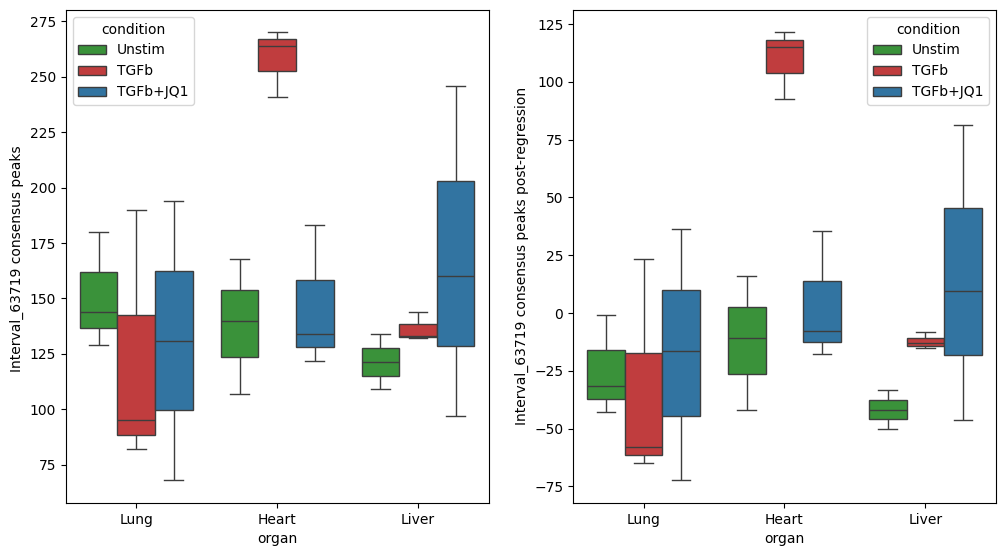

In [158]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = 'Interval_63719', ax=ax1)
plot_peak(atac_adata, peak = 'Interval_63719', ax=ax2, layer = 'post-regression')
plt.show()

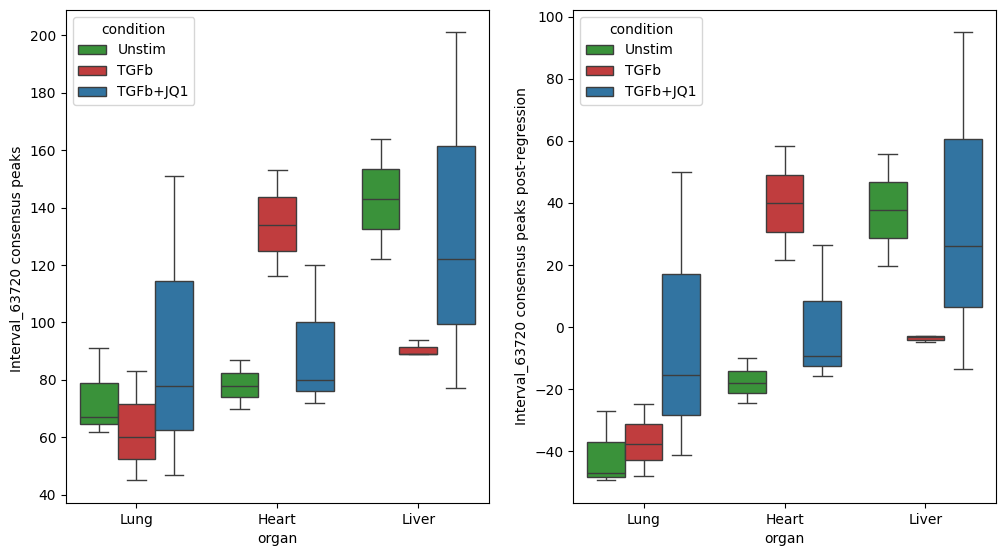

In [159]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = 'Interval_63720', ax=ax1)
plot_peak(atac_adata, peak = 'Interval_63720', ax=ax2, layer = 'post-regression')
plt.show()

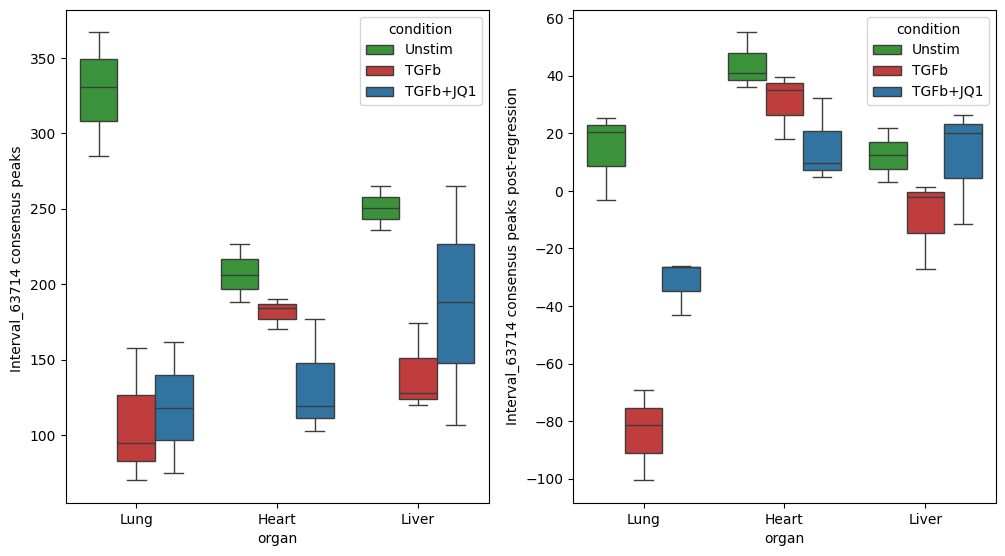

In [160]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = 'Interval_63714', ax=ax1)
plot_peak(atac_adata, peak = 'Interval_63714', ax=ax2, layer = 'post-regression')
plt.show()

### Methodology for identifying interesting peak-gene pairs
1. In one organ, identify genes with increased expression in TGFb and reduced in Unstim/JQ1.
2. For each gene, look within 150kb of TSS and identify peaks that show the same pattern across conditions.
3. Repeat steps 1 and 2 for each organ.
4. Compare/contrast peak-gene pairs across organs.
    - Can we identify organ-specific genes/enhancers?
    - Can we identify shared genes/enhancers?

In [161]:
def calc_condition_gene_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  condition_avg_df = organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates
  condition_avg_df['gene'] = organ_adata.var['gene']
  return condition_avg_df.groupby('gene', observed = False).aggregate('sum')  # Sum across gene variants

In [162]:
def calc_lfc(organ_df: pd.DataFrame) -> pd.DataFrame:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  lfc_df = pd.DataFrame({
    'up': np.log2(organ_df['TGFb'] / organ_df['Unstim']),
    'down': np.log2(organ_df['TGFb+JQ1'] / organ_df['TGFb'])
  })
  return lfc_df

In [163]:
def find_organ_genes(organ_df: pd.DataFrame, up_by: int = 0, down_by: int = 0) -> list[str]:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  upreg_genes = organ_df.index[(np.log2(organ_df['TGFb'] / organ_df['Unstim']) > up_by) & (np.log2(organ_df['TGFb+JQ1'] / organ_df['TGFb']) < down_by)]
  return upreg_genes

In [164]:
heart_rna_df = calc_condition_gene_averages(rna_adata, "Heart")
heart_rna_df.head()

condition,TGFb,TGFb+JQ1,Unstim
gene,,,
A1BG,1.130977,0.974347,1.287053
A1BG-AS1,1.837193,3.606701,1.548569
A1CF,0.001390,0.001376,0.000000
A2M,0.021714,0.005007,0.036045
A2M-AS1,0.107994,0.023121,0.074854


In [165]:
print(len(find_organ_genes(heart_rna_df)))
print(len(find_organ_genes(heart_rna_df, up_by=10)))
print(len(find_organ_genes(heart_rna_df, down_by=5)))
print(len(find_organ_genes(heart_rna_df, up_by=10, down_by=5)))

5601
671
10330
945


/share/pkg.8/python3/3.12.4/install/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [166]:
heart_rna_postreg_df = calc_condition_gene_averages(rna_adata, "Heart", layer = "post-regression")
heart_rna_postreg_df.head()

condition,TGFb,TGFb+JQ1,Unstim
gene,,,
A1BG,-0.097724,-0.182832,0.064359
A1BG-AS1,-1.205344,0.637908,-1.487773
A1CF,0.000726,0.000758,-0.000660
A2M,0.009249,-0.006020,0.023701
A2M-AS1,0.022881,-0.056753,-0.009818


In [167]:
print(len(find_organ_genes(heart_rna_postreg_df)))
print(len(find_organ_genes(heart_rna_postreg_df, up_by=10)))
print(len(find_organ_genes(heart_rna_postreg_df, down_by=5)))
print(len(find_organ_genes(heart_rna_postreg_df, up_by=10, down_by=5)))

3236
0
5206
0


/share/pkg.8/python3/3.12.4/install/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [168]:
print(len(find_organ_genes(heart_rna_postreg_df)))
print(len(find_organ_genes(heart_rna_postreg_df, up_by=5)))
print(len(find_organ_genes(heart_rna_postreg_df, down_by=5)))
print(len(find_organ_genes(heart_rna_postreg_df, up_by=5, down_by=5)))

3236
42
5206
69


In [169]:
heart_lfc_df = calc_lfc(heart_rna_postreg_df)

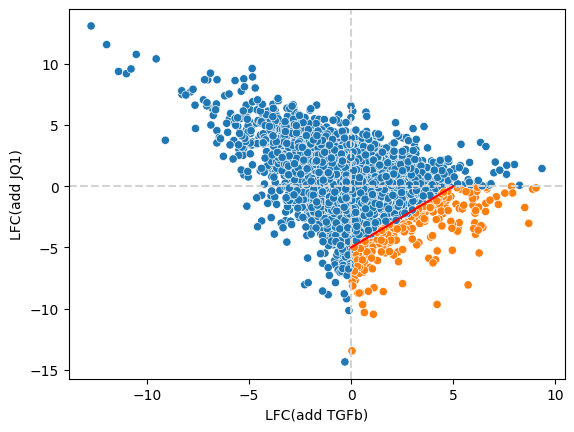

In [170]:
sns.scatterplot(heart_lfc_df, x = 'up', y = 'down', hue = (heart_lfc_df['up'] > 0) & (heart_lfc_df['down'] < 0) & (heart_lfc_df['up'] + np.abs(heart_lfc_df['down']) > 5), legend = None)
plt.xlabel("LFC(add TGFb)")
plt.ylabel("LFC(add JQ1)")
plt.axhline(0, linestyle='--', color = "lightgray")
plt.axvline(0, linestyle='--', color = "lightgray")
plt.plot((5, 0), (0, -5), color = "red")
plt.show()

In [171]:
heart_rna_postreg_df.loc['MEOX1']

condition
TGFb        12.743093
TGFb+JQ1    -1.726399
Unstim       0.019197
Name: MEOX1, dtype: float64

In [172]:
heart_rna_postreg_df.loc['POSTN']

condition
TGFb        -43.730725
TGFb+JQ1   -176.558262
Unstim      -77.844773
Name: POSTN, dtype: float64

In [173]:
def calc_condition_peak_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  return organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates

In [174]:
heart_atac_postreg_df = calc_condition_peak_averages(atac_adata, "Heart", layer = 'post-regression')

In [175]:
gene_to_peaks = {}
for gene in heart_lfc_df.index[(heart_lfc_df['up'] > 0) & (heart_lfc_df['down'] < 0) & (heart_lfc_df['up'] + np.abs(heart_lfc_df['down']) > 5)]:
  if not any(gene_locations['Symbol'] == gene):
    continue
  if sum(gene_locations['Symbol'] == gene) > 1:
    print(gene_locations.loc[gene_locations['Symbol'] == gene])
    continue
  chr, begin, end = gene_locations.loc[gene_locations['Symbol'] == gene][['Chromosome', 'Begin', 'End']].to_numpy().flatten()
  # chr, begin, end = row['Chromosome'], row['Begin'], row['End']
  peak_locs = atac_adata.var_names[
                                (atac_adata.var['Chr'] == f'chr{chr}') & 
                                (atac_adata.var['End'] >= begin - 1.5 * 10 ** 5) & 
                                (atac_adata.var['Start'] <= end + 1.5 * 10 ** 5)]
  gene_subset_df = heart_atac_postreg_df.loc[peak_locs]
  heart_peak_lfc_df = calc_lfc(gene_subset_df)
  gene_to_peaks[gene] = heart_peak_lfc_df


/share/pkg.8/python3/3.12.4/install/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/pkg.8/python3/3.12.4/install/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/pkg.8/python3/3.12.4/install/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/pkg.8/python3/3.12.4/install/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/pkg.8/python3/3.12.4/install/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/pkg

In [176]:
gene_to_peaks

{'ADAM20P1':                       up      down
 Geneid                            
 Interval_46707       NaN -0.539123
 Interval_46708       NaN -2.174927
 Interval_46709  0.836249 -1.567644
 Interval_46710 -0.406566 -0.663189
 Interval_46711  1.466361 -5.559599
 Interval_46712       NaN       NaN
 Interval_46713 -0.404622  0.390129
 Interval_46714 -0.673221 -0.226553
 Interval_46715  2.818458       NaN
 Interval_46716  0.357667  0.152417
 Interval_46717       NaN       NaN
 Interval_46718 -1.062179       NaN
 Interval_46719 -0.094384 -0.285881,
 'ADAM28':                        up      down
 Geneid                             
 Interval_147388 -0.567353 -3.197062
 Interval_147389 -1.584948  0.133729
 Interval_147390 -1.200868       NaN
 Interval_147391  0.481196 -1.563441
 Interval_147392 -1.548225  0.750423
 Interval_147393       NaN       NaN
 Interval_147394  0.274012       NaN
 Interval_147395       NaN       NaN
 Interval_147396  3.930269 -2.590129
 Interval_147397       NaN    

In [179]:
heart_rna_postreg_df.loc['MEOX1']

condition
TGFb        12.743093
TGFb+JQ1    -1.726399
Unstim       0.019197
Name: MEOX1, dtype: float64

In [178]:
heart_lfc_df.loc['MEOX1']

up      9.374641
down         NaN
Name: MEOX1, dtype: float64

In [177]:
gene_to_peaks['MEOX1']

KeyError: 'MEOX1'